### SHRED applied to SST dataset

This iPython notebook gives an introductory walkthrough to using SHRED models.  The dataset we consider is weekly mean sea-surface temperature as given by the NOAA Optimum Interpolation SST V2 dataset (https://psl.noaa.gov/data/gridded/data.noaa.oisst.v2.html).

SHRED (SHallow REcurrent Decoder) models are a network architecture that merges a recurrent layer (LSTM) with a shallow decoder network (SDN) to reconstruct high-dimensional spatio-temporal fields from a trajectory of sensor measurements of the field. More formally, the SHRED architecture can be written as 
$$ \mathcal {H} \left( \{ y_i \} _{i=t-k}^t \right) = \mathcal {F} \left( \mathcal {G} \left( \{ y_i \} _{i=t-k}^t \right) ; W_{RN}) ; W_{SD} \right)$$
where $\mathcal F$ is a feed forward network parameterized by weights $W_{SD}$, $\mathcal G$ is a LSTM network parameterized by weights $W_{RN}$, and $\{ y_i \} _{i=t-k}^t$ is a trajectory of sensor measurements of a high-dimensional spatio-temporal field $\{ x_i \} _{i=t-k}^t$.

We first randomly select 3 sensor locations and set the trajectory length (lags) to 52, corresponding to one year of measurements.

In [2]:
import numpy as np
from processdata import load_data
from processdata import TimeSeriesDataset
import models
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

num_sensors = 3 
lags = 52
load_X = load_data('SST')
n = load_X.shape[0]
m = load_X.shape[1]
sensor_locations = np.random.choice(m, size=num_sensors, replace=False)

We now select indices to divide the data into training, validation, and test sets.

In [3]:
train_indices = np.random.choice(n - lags, size=1000, replace=False)
mask = np.ones(n - lags)
mask[train_indices] = 0
valid_test_indices = np.arange(0, n - lags)[np.where(mask!=0)[0]]
valid_indices = valid_test_indices[::2]
test_indices = valid_test_indices[1::2]

sklearn's MinMaxScaler is used to preprocess the data for training and we generate input/output pairs for the training, validation, and test sets. 

In [4]:
sc = MinMaxScaler()
sc = sc.fit(load_X[train_indices])
transformed_X = sc.transform(load_X)

### Generate input sequences to a SHRED model
all_data_in = np.zeros((n - lags, lags, num_sensors))
for i in range(len(all_data_in)):
    all_data_in[i] = transformed_X[i:i+lags, sensor_locations]

### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

### -1 to have output be at the same time as final sensor measurements
train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

We train the model using the training and validation datasets.

In [8]:
shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
validation_errors = models.fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=1000, lr=1e-3, verbose=True, patience=5)

Training epoch 1
Error tensor(0.4783)
Training epoch 20
Error tensor(0.2270)
Training epoch 40
Error tensor(0.2188)
Training epoch 60
Error tensor(0.2072)
Training epoch 80
Error tensor(0.2061)
Training epoch 100
Error tensor(0.1960)
Training epoch 120
Error tensor(0.1901)
Training epoch 140
Error tensor(0.1770)
Training epoch 160
Error tensor(0.1671)
Training epoch 180
Error tensor(0.1592)
Training epoch 200
Error tensor(0.1533)
Training epoch 220
Error tensor(0.1478)
Training epoch 240
Error tensor(0.1405)
Training epoch 260
Error tensor(0.1364)
Training epoch 280
Error tensor(0.1306)
Training epoch 300
Error tensor(0.1299)
Training epoch 320
Error tensor(0.1258)
Training epoch 340
Error tensor(0.1248)
Training epoch 360
Error tensor(0.1228)
Training epoch 380
Error tensor(0.1221)
Training epoch 400
Error tensor(0.1186)
Training epoch 420
Error tensor(0.1174)
Training epoch 440
Error tensor(0.1167)
Training epoch 460
Error tensor(0.1170)
Training epoch 480
Error tensor(0.1170)
Traini

Finally, we generate reconstructions from the test set and print mean square error compared to the ground truth.

In [9]:
test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
print(np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth))

0.020035379


2. Train the model and plot the results

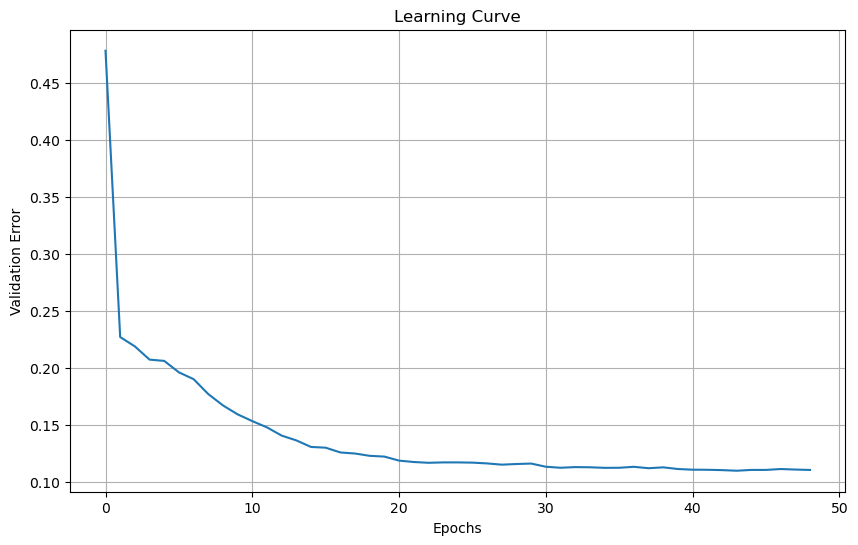

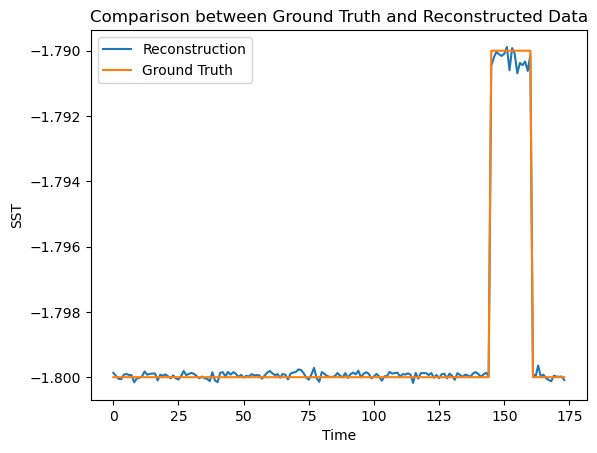

In [10]:
#Plot the results

# Plot the validation errors (Learning curve)
plt.figure(figsize=(10, 6))
plt.plot(validation_errors)
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Validation Error')
plt.grid(True)
plt.show()

# Plot the ground truth and the reconstructed data
plt.plot(test_recons[:, 0], label='Reconstruction')
plt.plot(test_ground_truth[:, 0], label='Ground Truth')
plt.title('Comparison between Ground Truth and Reconstructed Data')
plt.xlabel('Time')
plt.ylabel('SST')
plt.legend()
plt.show()


3. Do an analysis of the performance as a function of the time lag variable

Training epoch 1
Error tensor(0.4840)
Training epoch 20
Error tensor(0.2875)
Training epoch 40
Error tensor(0.2580)
0.04896924
Training epoch 1
Error tensor(0.4711)
Training epoch 20
Error tensor(0.2717)
Training epoch 40
Error tensor(0.2409)
0.045311417
Training epoch 1
Error tensor(0.4641)
Training epoch 20
Error tensor(0.2448)
Training epoch 40
Error tensor(0.2291)
0.043475777
Training epoch 1
Error tensor(0.4819)
Training epoch 20
Error tensor(0.2280)
Training epoch 40
Error tensor(0.2259)
0.040313024
Training epoch 1
Error tensor(0.4821)
Training epoch 20
Error tensor(0.2244)
Training epoch 40
Error tensor(0.2186)
0.037693784


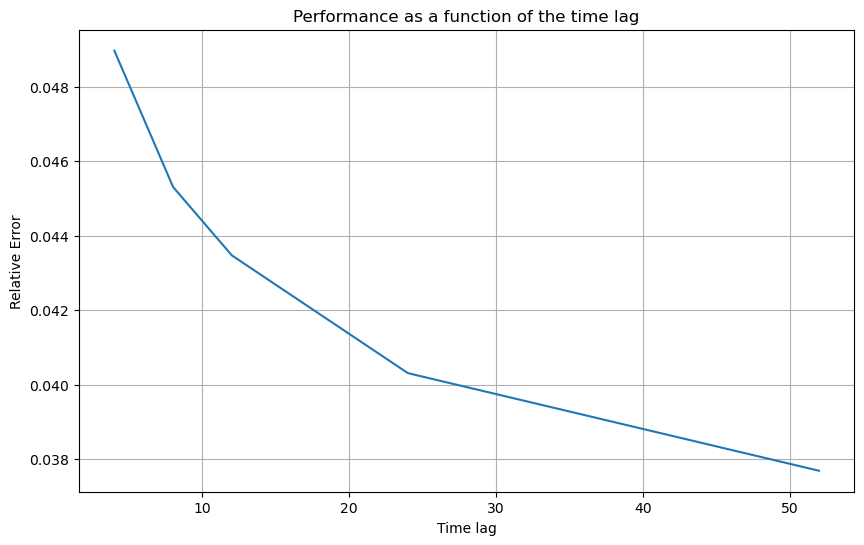

In [12]:
# Retrain the model for various values of the time lag and compare the results. 

# Define a list of different lag values to test
lags2 = [4, 8, 12, 24, 52]

# Initialize an empty list to store the results
results = []

# Loop over the list of lag values
for lag in lags2:

    # Prepare the input/output pairs for the given lag
    all_data_in = np.zeros((n - lag, lag, num_sensors))
    for i in range(len(all_data_in)):
        all_data_in[i] = transformed_X[i:i+lag, sensor_locations]
    
    # Generate training validation and test datasets both for reconstruction of states and forecasting sensors
    # The following lines of code remain the same, only replace 'lags' with 'lag'
    train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
    valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
    test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

    train_data_out = torch.tensor(transformed_X[train_indices + lag - 1], dtype=torch.float32).to(device)
    valid_data_out = torch.tensor(transformed_X[valid_indices + lag - 1], dtype=torch.float32).to(device)
    test_data_out = torch.tensor(transformed_X[test_indices + lag - 1], dtype=torch.float32).to(device)

    train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
    valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
    test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

    # Train the model
    shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
    validation_errors = models.fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=50, lr=1e-3, verbose=True, patience=5)


    test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
    test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
    print(np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth))


    # Append the result to the results list
    results.append(np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth))

# Convert the results to a numpy array for easier handling
results = np.array(results)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(lags2, results)
plt.title('Performance as a function of the time lag')
plt.xlabel('Time lag')
plt.ylabel('Relative Error')
plt.grid(True)
plt.show()


4. Do an analysis of the performance as a function of noise (add Gaussian noise to data)

Training epoch 1
Error tensor(0.4757)
Training epoch 20
Error tensor(0.2244)
Training epoch 40
Error tensor(0.2188)
0.038268097
Training epoch 1
Error tensor(0.4849)
Training epoch 20
Error tensor(0.2482)
Training epoch 40
Error tensor(0.2434)
0.043998066
Training epoch 1
Error tensor(0.5094)
Training epoch 20
Error tensor(0.3030)
Training epoch 40
Error tensor(0.2999)
0.05885229
Training epoch 1
Error tensor(0.5447)
Training epoch 20
Error tensor(0.3699)
Training epoch 40
Error tensor(0.3688)
0.07640116
Training epoch 1
Error tensor(0.5859)
Training epoch 20
Error tensor(0.4415)
Training epoch 40
Error tensor(0.4415)
0.095879376
Training epoch 1
Error tensor(0.6321)
Training epoch 20
Error tensor(0.5094)
Training epoch 40
Error tensor(0.5092)
0.116798565
Training epoch 1
Error tensor(0.6704)
Training epoch 20
Error tensor(0.5707)
Training epoch 40
Error tensor(0.5703)
0.13731669


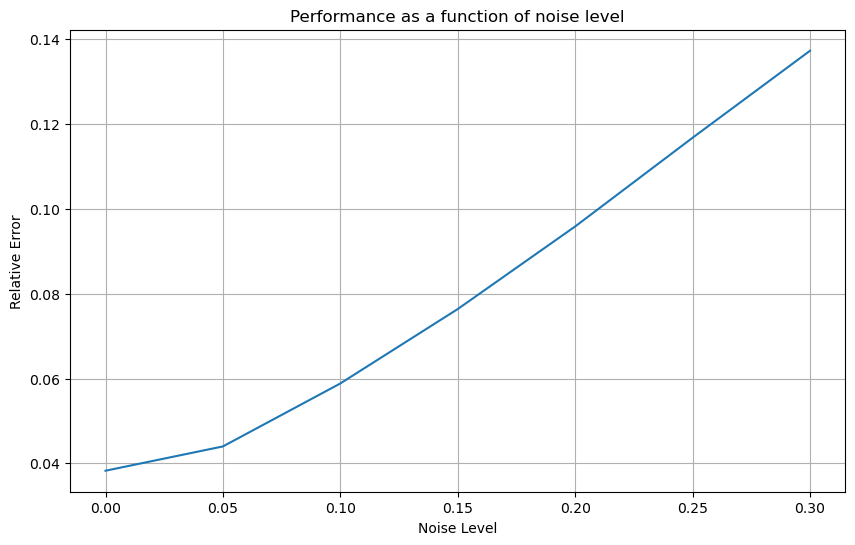

In [29]:
# Do an analysis of the performance as a function of noise (add Gaussian noise to data)

# Define a list of different noise levels to test
noise_levels = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]

# Initialize an empty list to store the results
results = []

# Loop over the list of noise levels
for noise_level in noise_levels:

    # Add Gaussian noise to the data
    noisy_X = transformed_X + np.random.normal(0, noise_level, transformed_X.shape)

    # Prepare the input/output pairs
    all_data_in = np.zeros((n - lags, lags, num_sensors))
    for i in range(len(all_data_in)):
        all_data_in[i] = noisy_X[i:i+lags, sensor_locations]
    
    # Generate training validation and test datasets both for reconstruction of states and forecasting sensors
    train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
    valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
    test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

    train_data_out = torch.tensor(noisy_X[train_indices + lags - 1], dtype=torch.float32).to(device)
    valid_data_out = torch.tensor(noisy_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
    test_data_out = torch.tensor(noisy_X[test_indices + lags - 1], dtype=torch.float32).to(device)

    train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
    valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
    test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

    # Train the model
    shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
    validation_errors = models.fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=50, lr=1e-3, verbose=True, patience=5)

    # Generate reconstructions from the test set
    test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
    test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
    print(np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth))


    # Append the result to the results list
    results.append(np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth))

# Convert the results to a numpy array for easier handling
results = np.array(results)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(noise_levels, results)
plt.title('Performance as a function of noise level')
plt.xlabel('Noise Level')
plt.ylabel('Relative Error')
plt.grid(True)
plt.show()



5. Do an analysis of the performance as a function of the number of sensors

Training epoch 1
Error tensor(0.4840)
Training epoch 20
Error tensor(0.2252)
Training epoch 40
Error tensor(0.2208)
0.03911103
Training epoch 1
Error tensor(0.4838)
Training epoch 20
Error tensor(0.2244)
Training epoch 40
Error tensor(0.2209)
0.03769584
Training epoch 1
Error tensor(0.4811)
Training epoch 20
Error tensor(0.2271)
Training epoch 40
Error tensor(0.2199)
0.03786234
Training epoch 1
Error tensor(0.4800)
Training epoch 20
Error tensor(0.2272)
Training epoch 40
Error tensor(0.2197)
0.038070507
Training epoch 1
Error tensor(0.4782)
Training epoch 20
Error tensor(0.2199)
Training epoch 40
Error tensor(0.2002)
0.03724395
Training epoch 1
Error tensor(0.4860)
Training epoch 20
Error tensor(0.2231)
Training epoch 40
Error tensor(0.2155)
0.037825864
Training epoch 1
Error tensor(0.4791)
Training epoch 20
Error tensor(0.2219)
Training epoch 40
Error tensor(0.2172)
0.0372681
Training epoch 1
Error tensor(0.4790)
Training epoch 20
Error tensor(0.2219)
Training epoch 40
Error tensor(0.

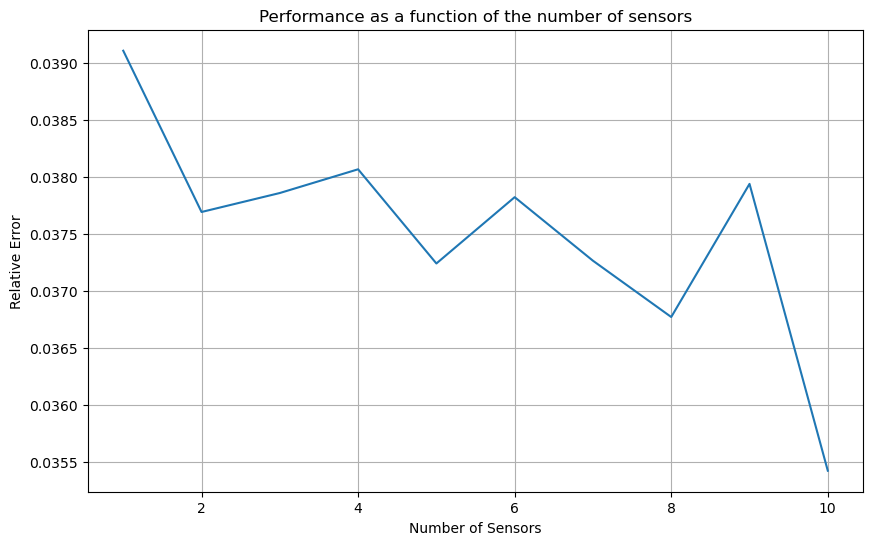

In [13]:
# Define a list of different numbers of sensors to test
num_sensors_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Initialize an empty list to store the results
results = []

# Loop over the list of numbers of sensors
for num_sensors in num_sensors_values:

    # Select sensor locations randomly
    sensor_locations = np.random.choice(m, size=num_sensors, replace=False)

    # Prepare the input/output pairs
    all_data_in = np.zeros((n - lags, lags, num_sensors))
    for i in range(len(all_data_in)):
        all_data_in[i] = transformed_X[i:i+lags, sensor_locations]

    # Generate training validation and test datasets
    train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
    valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
    test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

    train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
    valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
    test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

    train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
    valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
    test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

    # Train the model
    shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
    validation_errors =  models.fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=50, lr=1e-3, verbose=True, patience=5)

    # Generate reconstructions from the test set
    test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
    test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
    print(np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth))

    # Append the result to the results list
    results.append(np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth))

# Convert the results to a numpy array for easier handling
results = np.array(results)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(num_sensors_values, results)
plt.title('Performance as a function of the number of sensors')
plt.xlabel('Number of Sensors')
plt.ylabel('Relative Error')
plt.grid(True)
plt.show()
